# Import libraries

In [33]:
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nlp_id.lemmatizer import Lemmatizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import re
import itertools

# Load and preproccess data

In [2]:
df = pd.read_csv('./data_full.csv')

lemmatizer = Lemmatizer()
stop_words = stopwords.words("indonesian")
word_detokenizer = TreebankWordDetokenizer()

df['sentence_text_cleaned'] = df['sentence_text'].str.lower()
df['sentence_text_cleaned'] = df['sentence_text_cleaned'].apply(lambda s: re.sub(r'[^\w\s]', '', re.sub(r'\d+', '', s)))
df['sentence_text_cleaned'] = df['sentence_text_cleaned'].apply(lambda s: lemmatizer.lemmatize(s))
df['sentence_text_cleaned'] = df['sentence_text_cleaned'].apply(lambda s: [v for v in s.split() if v not in stop_words])
df['sentence_text_cleaned'] = df['sentence_text_cleaned'].apply(lambda s: word_detokenizer.detokenize(s))

# Group sentences based on their labels

In [3]:
labels = ['F1', 'F2', 'F3', 'F4', 'F5', 'F6']

for label in labels:
    f = open(f"sentence_labels/{label}.txt", 'w')
    for _, row in df.iterrows():
        if row['label_annotator'] == label:
            f.write(row['sentence_text_cleaned'] + "\n")
    f.close()

# Create document frequency for each word in each label

In [4]:
for label in labels:
    with open(f"sentence_labels/{label}.txt") as f:
        sentences = f.readlines()

    sentences = [sentence.strip() for sentence in sentences]
    unique_words = set([word for sentence in sentences for word in sentence.split() if len(word) > 1])
    doc_freq = {word: 0 for word in unique_words}

    for sentence in sentences:
        words_in_sentence = set(sentence.split())
        for word in unique_words:
            if word in words_in_sentence:
                doc_freq[word] += 1
        
    doc_freq = {
        'word': doc_freq.keys(),
        'doc_freq': doc_freq.values(),
    }
    
    doc_freq = pd.DataFrame(doc_freq)
    doc_freq = doc_freq.sort_values('doc_freq', ascending=False)
    doc_freq.to_csv(f"sentence_labels/DF_{label}.csv", index=False)

# Make new document based on the segmentation

In [5]:
segment_label = {
    'doc_id': [],
    'segment_id': [],
    'segment_text': [],
}

for doc_id in range(500):
    if doc_id == 87: continue
    seg_ids = df.loc[df['doc_id'] == doc_id, 'optimal_segment_id'].unique()
    for seg_id in seg_ids:
        seg_text = df.loc[df['optimal_segment_id'] == seg_id, 'sentence_text'].to_list()
        seg_text = ' '.join(seg_text)
        segment_label['doc_id'].append(doc_id)
        segment_label['segment_id'].append(seg_id)
        segment_label['segment_text'].append(seg_text)

segment_label = pd.DataFrame(segment_label)
segment_label.to_csv('segment_optimal_label.csv', index=False)

In [6]:
segment_label

,doc_id,segment_id,segment_text
0,0,s0_0,"Halo yayan, Terima kasih atas pertanyaannya"
1,0,s0_1,Berdasarkan riwayat keluhan istri Anda yang su...
2,0,s0_2,"Minum air, sup, atau minuman elektrolit untuk ..."
3,0,s0_3,Apabila gejala tidak membaik dalam waktu 3 - 5...
4,1,s1_0,Halo Terima kasih atas pertanyaan yang disampa...
...,...,...,...
2701,498,s498_5,"Semoga membantu, dr Mira"
2702,499,s499_0,Hai Nyeri perut setelah buang air kecil dapat ...
2703,499,s499_1,Untuk memastikan penyebabnya tentunya diperluk...
2704,499,s499_2,Berikut ini anjuran bagi Anda: Istirahat yang ...


# Preproccess segment text

In [7]:
segment_label['segment_text_cleaned'] = segment_label['segment_text'].str.lower()
segment_label['segment_text_cleaned'] = segment_label['segment_text_cleaned'].apply(lambda s: re.sub(r'[^\w\s]', '', re.sub(r'\d+', '', s)))
segment_label['segment_text_cleaned'] = segment_label['segment_text_cleaned'].apply(lambda s: lemmatizer.lemmatize(s))
segment_label['segment_text_cleaned'] = segment_label['segment_text_cleaned'].apply(lambda s: [v for v in s.split() if v not in stop_words])
segment_label['segment_text_cleaned'] = segment_label['segment_text_cleaned'].apply(lambda s: word_detokenizer.detokenize(s))

# Make new dictionary to store each label's word count

In [8]:
df_dict = {}

for label in labels:
    df_dict[label] = pd.read_csv(f"sentence_labels/DF_{label}.csv")

# Create new columns for storing word count & start counting

In [9]:
segment_label['F1'] = 0
segment_label['F2'] = 0
segment_label['F3'] = 0
segment_label['F4'] = 0
segment_label['F5'] = 0
segment_label['F6'] = 0
segment_label['predicted_label'] = ''

for i, row in segment_label.iterrows():
    sentence = row['segment_text_cleaned'].split()
    for word in sentence:
        for label in labels:
            if df_dict[label]['word'].isin([word]).any():
                segment_label.loc[i, label] += 1

# Predict the label

based on the largest value from all the 6 labels, in case there are more than one largest value (they are the same), then set the label to Fx

In [10]:
# get the columns for F1-F6
f_cols = segment_label.loc[:, 'F1':'F6'].columns

# get the index of the column with the highest count for each row
max_cols = segment_label[f_cols].idxmax(axis=1)

# get the maximum count for each row
max_counts = segment_label[f_cols].max(axis=1)

# set the 'predicted_label' column to the column with the highest count or 'Fx' if there are multiple columns with the same maximum count
segment_label['predicted_label'] = np.where(max_counts.eq(max_counts.groupby(level=0).transform('max')), max_cols, 'Fx')

In [11]:
segment_label

,doc_id,segment_id,segment_text,segment_text_cleaned,F1,F2,F3,F4,F5,F6,predicted_label
0,0,s0_0,"Halo yayan, Terima kasih atas pertanyaannya",halo yayan terima kasih,4,0,1,0,2,0,F1
1,0,s0_1,Berdasarkan riwayat keluhan istri Anda yang su...,dasar riwayat keluh istri muntah muntah diare ...,16,37,70,64,69,45,F3
2,0,s0_2,"Minum air, sup, atau minuman elektrolit untuk ...",minum air sup minum elektrolit bantu cair tubu...,2,9,25,21,30,13,F5
3,0,s0_3,Apabila gejala tidak membaik dalam waktu 3 - 5...,gejala muntah diare darah demam lemas langsung...,10,9,14,14,17,9,F5
4,1,s1_0,Halo Terima kasih atas pertanyaan yang disampa...,halo terima kasih alodokter paham khawatir,6,0,3,2,5,0,F1
...,...,...,...,...,...,...,...,...,...,...,...
2701,498,s498_5,"Semoga membantu, dr Mira",moga bantu dr mira,4,0,1,2,2,0,F1
2702,499,s499_0,Hai Nyeri perut setelah buang air kecil dapat ...,hai nyeri perut buang air infeksi salur kemih ...,6,14,19,18,18,13,F3
2703,499,s499_1,Untuk memastikan penyebabnya tentunya diperluk...,periksa keluh langsung konsultasi dokter laku ...,5,11,18,17,18,6,F3
2704,499,s499_2,Berikut ini anjuran bagi Anda: Istirahat yang ...,anjur istirahat konsumsi makan gizi daya tahan...,10,19,40,39,42,23,F5


# Cosine Similarity for each label

Make a single, very-long sentence from all the words in each label (F1-F6), then compare it to each predicted segment using cosine similarity. If the value is ≥ 0.75, the label is accurate

In [12]:
segment_label['cosine_similarity'] = ''

In [13]:
def addCosineSimilarity(label: str):
    f = open(f"sentence_labels/{label}.txt")
    sentences = [s.strip() for s in f.readlines()]
    sentences = [" ".join(list(itertools.chain.from_iterable(list(filter(lambda s: len(s) > 1, [s.split() for s in sentences])))))]

    for _, row in segment_label.iterrows():
        if row['predicted_label'] == label:
            sentences.append(row['segment_text_cleaned'])

    vectorizer = CountVectorizer()
    x = vectorizer.fit_transform(sentences)
    similarities = pd.DataFrame(cosine_similarity(x))

    i = 1
    for index, row in segment_label.iterrows():
        if row['predicted_label'] == label:
            segment_label.loc[index, 'cosine_similarity'] = similarities[0][i]
            i += 1

In [14]:
addCosineSimilarity('F1')
addCosineSimilarity('F2')
addCosineSimilarity('F3')
addCosineSimilarity('F4')
addCosineSimilarity('F5')
addCosineSimilarity('F6')

In [75]:
segment_label['is_label_correct'] = segment_label['cosine_similarity'].apply(lambda x: 1 if x >= 0.45 else 0)

In [76]:
counts = segment_label['is_label_correct'].value_counts()
print(counts)

0    2078
1     628
Name: is_label_correct, dtype: int64


In [17]:
label_counts = segment_label['predicted_label'].value_counts()
print(label_counts)

F3    1547
F1     560
F5     454
F4     123
F2      19
F6       3
Name: predicted_label, dtype: int64


In [18]:
segment_label.to_csv('segment_label_cossim.csv', index=False)

<Axes: >

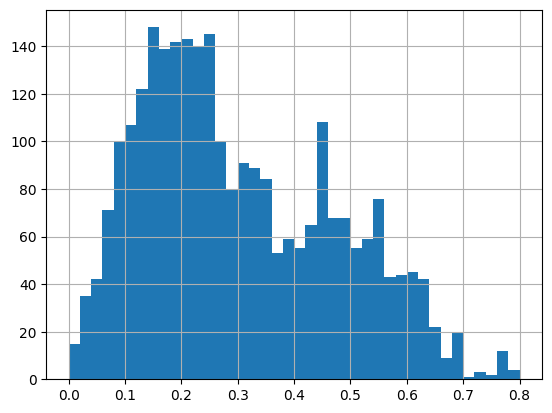

In [60]:
segment_label.cosine_similarity.astype(float).round(2).hist(bins=40)

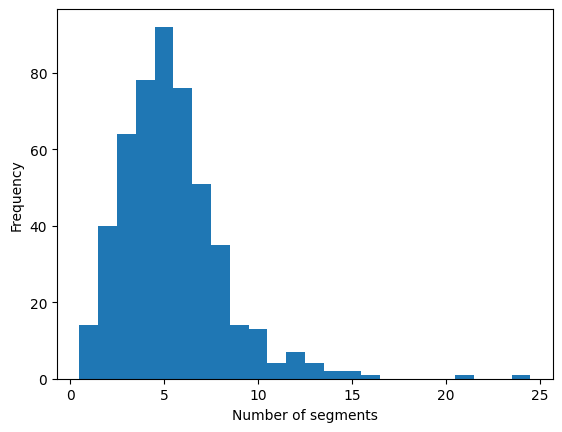

In [65]:
counts = segment_label.groupby('doc_id').count()['segment_id']

# plot the histogram of the counts
counts.plot.hist(bins=range(1, max(counts)+2), align='left')

# set the x-axis label
plt.xlabel('Number of segments')

# set the y-axis label
plt.ylabel('Frequency')

# show the plot
plt.show()